In [1]:
import os

import matplotlib.pyplot as plt
import torch
from dataset_creation.utils import get_n_random_noises, create_noisy_traces
from snr.calc_snr import CalcSNR, SnrCalcStrategy

## Requirements And Configuration

The generated noisy traces should be a synthetic version of traces taken from the following dataset ('ethz', 'geofon'):

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'geofon'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:

NUM_SAMPLES=3001                    # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
NUM_NOISY_VERSIONS_PER_TRACE=2      # How many noisy versions to synthesize using a single real trace
DESIRED_SNR=2                       # What SNR level should the noisy synthesized trace be
SAMPLING_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz


If the generated noises should allow shifting experiments they should be longer than the original trace.
Define how many 1-second-shifts will the dataset enable.

In [4]:
NUM_SHIFTS=6
AUGMENTED_WINDOW_SIZE=NUM_SAMPLES+SAMPLING_RATE*NUM_SHIFTS

Browse The path of the **event** traces that will be used for synthesizing.

In [5]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_trainset_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'

Browse The path of the **noise** traces that will be used for synthesizing.

In [6]:
NOISES_PATH='/home/moshe/datasets/GFZ/Noises'

In [7]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')

assert os.path.exists(DATASET_PATH), f'Directory {DATASET_PATH} does not exist'
assert os.path.exists(dataset_traces_path), f'file {dataset_traces_path} does not exist'
assert os.path.exists(dataset_labels_path), f'file {dataset_labels_path} does not exist'

## Load Dataset

In [8]:
dataset=torch.load(dataset_traces_path)[:60]
labels=torch.load(dataset_labels_path)[:60]

num_traces = dataset.shape[0]
num_labels = labels.shape[0]
num_samples = dataset.shape[-1]

assert num_labels==num_traces, f'Expected traces equal num labels.Got {num_traces} traces and {num_labels} labels'
assert num_samples==NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_samples}.'

print(f'Loaded {num_traces} traces and corresponding labels.')

Loaded 60 traces and corresponding labels.


## Create a Noisy Dataset

In [9]:
def create_single_noisy_version():
    # prepare full noises traces
    full_noise_traces: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH,force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()
    print(f'Loaded {full_noise_traces.shape[0]} noise traces. shape {full_noise_traces.shape}')
    # Trim the noise traces. Adjust to dataset num samples.
    noise_traces: torch.tensor = full_noise_traces[:,:,:NUM_SAMPLES].clone()

    print(f'Trimmed {noise_traces.shape[0]} noise traces to shape {noise_traces.shape}')
    # Create the noisy traces and get the ones that did not succeed
    version_noised_traces_list, version_noise_factors, version_not_included_indices = create_noisy_traces(dataset=dataset,desired_snr=DESIRED_SNR, labels=labels, noise_traces=noise_traces, calc_snr=CalcSNR(SnrCalcStrategy.ENERGY_RATIO))
    print(f'Created {len(version_noised_traces_list)} noisy traces')
    print(f'The following indices are not included {version_not_included_indices}')
    # Remove the corresponding indices from the full noises list and the label list
    included_indices_list = [i for i in range(num_traces) if i not in version_not_included_indices]
    version_labels = labels[included_indices_list].clone()
    version_full_noise_traces = full_noise_traces[included_indices_list].clone()
    return torch.stack(version_noised_traces_list, dim=0), version_labels, version_full_noise_traces, torch.tensor(version_noise_factors)

In [10]:
version_noised_traces_list, version_labels_list, version_augmented_noise_traces_list, version_factors_list = [],[],[],[]

In [11]:
# all_noised_traces, all_labels, all_full_noise_traces, all_factors =  create_single_noisy_version()
# for snr in range(2,12):
for i in range(NUM_NOISY_VERSIONS_PER_TRACE):
    version_noised_traces, version_labels, version_full_noise_traces, version_factors =  create_single_noisy_version()
    version_noised_traces_list.append(version_noised_traces)
    version_labels_list.append(version_labels.unsqueeze(dim=1))
    version_augmented_noise_traces_list.append(version_full_noise_traces)
    version_factors_list.append(version_factors.unsqueeze(dim=1))
    print(len(version_noised_traces_list), len(version_labels_list), len(version_augmented_noise_traces_list), len(version_factors_list))

100%|██████████| 60/60 [00:00<00:00, 100.05it/s]


Created a list of 60 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([60, 3, 3601])
Loaded 60 noise traces. shape torch.Size([60, 3, 3601])
Trimmed 60 noise traces to shape torch.Size([60, 3, 3001])


100%|██████████| 60/60 [00:00<00:00, 228.73it/s]


Created 57 noisy traces
The following indices are not included [15, 25, 27]
1 1 1 1


100%|██████████| 60/60 [00:00<00:00, 171.11it/s]


Created a list of 60 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([60, 3, 3601])
Loaded 60 noise traces. shape torch.Size([60, 3, 3601])
Trimmed 60 noise traces to shape torch.Size([60, 3, 3001])


100%|██████████| 60/60 [00:00<00:00, 159.34it/s]

Created 56 noisy traces
The following indices are not included [20, 30, 31, 52]
2 2 2 2


In [12]:
noised_traces = torch.vstack(version_noised_traces_list)
noised_traces_labels = torch.vstack(version_labels_list).squeeze()
augmented_noise_traces = torch.vstack(version_augmented_noise_traces_list)
noising_factors = torch.vstack(version_factors_list).squeeze()
noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape

(torch.Size([113, 3, 3001]),
 torch.Size([113]),
 torch.Size([113, 3, 3601]),
 torch.Size([113]))

In [13]:
noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_testtesttest_dataset_snr_{DESIRED_SNR}')
noisy_dataset_path

'/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_testtesttest_dataset_snr_2'

In [15]:
assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'

AssertionError: Path /home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_testtesttest_dataset_snr_2 does not exist.Create it

In [14]:
torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))

RuntimeError: Parent directory /home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_testtesttest_dataset_snr_2 does not exist.

## Plot Noising Example

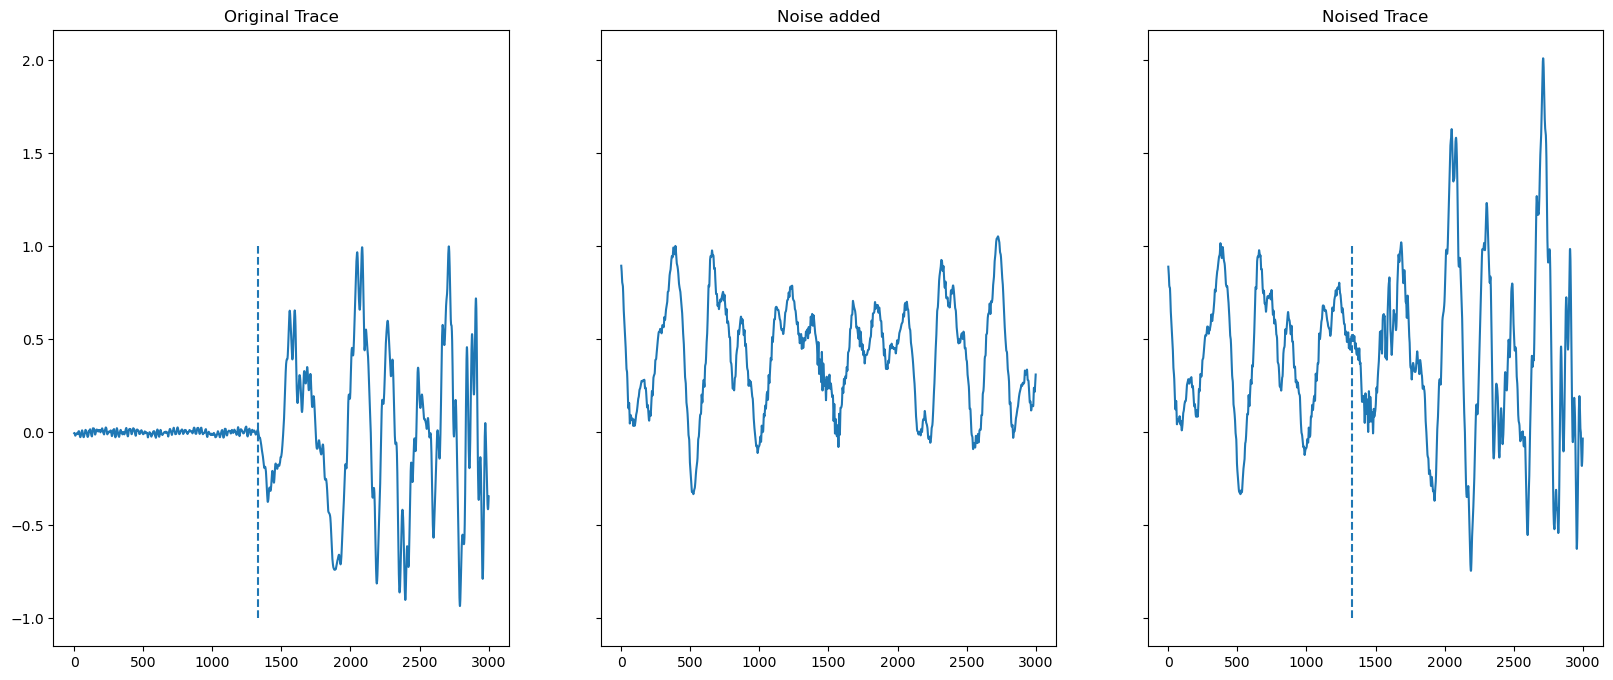

In [20]:
idx = 5
trace  = noised_traces[idx]
label  = noised_traces_labels[idx]
factor = noising_factors[idx]
noise = augmented_noise_traces[idx, :, :trace.shape[-1] ]
trace.shape, label, factor, noise.shape
fig, (ax_orig,ax_noise, ax_noised) = plt.subplots(1,3,figsize=(20,8), sharey='all')

ax_orig.plot((trace - factor * noise)[0]);
ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
ax_orig.set_title('Original Trace')
ax_noise.plot(factor*noise[0]);
ax_noise.set_title('Noise added')
ax_noised.plot(trace[0]);
ax_noised.set_title('Noised Trace')

ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');


# ax_orig.plot((trace - factor * noise).T)
# ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')
# ax_noise.plot(noise.T)
# ax_noised.plot(trace.T)
# ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')